<a href="https://colab.research.google.com/github/ahmedelbehery99/Arabic-Handwritten-OCR/blob/master/arabicWordRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloads and Imports

In [1]:
!pip install python-Levenshtein
!pip install arabic-reshaper
!pip install python-bidi

     |████████████████████████████████| 50 kB 1.4 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149864 sha256=ba3a3fe03db20e3fa62f79246b418f3249951f2911dd6692e435b67af113f802
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [2]:
import numpy as np
import cv2 as cv
import os
import re
import random
from glob import glob
from tqdm import tqdm
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection  import train_test_split
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn import multioutput
import pickle
import glob
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model
from pickle import dump
import cv2
from matplotlib import pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display

In [3]:
!wget http://www.ifnenit.com/download/ifnenit-database-demo.tar.gz

--2022-03-26 07:22:51--  http://www.ifnenit.com/download/ifnenit-database-demo.tar.gz
Resolving www.ifnenit.com (www.ifnenit.com)... 217.160.0.154
Connecting to www.ifnenit.com (www.ifnenit.com)|217.160.0.154|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4870140 (4.6M) [application/gzip]
Saving to: ‘ifnenit-database-demo.tar.gz’

ifnenit-database-de 100%[===================>]   4.64M  4.81MB/s    in 1.0s    

2022-03-26 07:22:52 (4.81 MB/s) - ‘ifnenit-database-demo.tar.gz’ saved [4870140/4870140]



In [4]:
!tar -xvf /content/ifnenit-database-demo.tar.gz

ifnenit-database-demo/
ifnenit-database-demo/doc/
ifnenit-database-demo/doc/arabic_label_to_latin_label_lookup_table_plus_statistic.pdf
ifnenit-database-demo/doc/tunisian_town_village_list.pdf
ifnenit-database-demo/doc/README.pdf
ifnenit-database-demo/doc/page_writer_tab_set_X.README
ifnenit-database-demo/doc/page_writer_tab_set_a.txt
ifnenit-database-demo/doc/page_writer_tab_set_b.txt
ifnenit-database-demo/doc/page_writer_tab_set_c.txt
ifnenit-database-demo/doc/page_writer_tab_set_d.txt
ifnenit-database-demo/data/
ifnenit-database-demo/data/forms/
ifnenit-database-demo/data/forms/pa511.tif.gz
ifnenit-database-demo/data/forms/pa507.tif.gz
ifnenit-database-demo/data/forms/pa382.tif.gz
ifnenit-database-demo/data/forms/pa094.tif.gz
ifnenit-database-demo/data/forms/pa024.tif.gz
ifnenit-database-demo/data/forms/pa485.tif.gz
ifnenit-database-demo/data/forms/pa085.tif.gz
ifnenit-database-demo/data/forms/pb339.tif.gz
ifnenit-database-demo/data/forms/pa634.tif.gz
ifnenit-database-demo/data/form

# Data Preparation

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
texts = glob.glob('/content/ifnenit-database-demo/data/set_a/tru/*')

In [7]:
dic = {
'hhA': 'ء',
'amA': 'ﺁ',
'aeA': 'أ',
'ahA': 'إ',
'aeElaB': 'أل',
'ahElaB': 'إل',
'alM': 'ئ',
'aaA': 'ا',
'aaE': 'ا',
'aaElaB': 'ال',
'aaElaM': 'ال',
'baA': 'ب',
'baB': 'ب',
'baE': 'ب',
'baM': 'ب',
'teA': 'ة',
'taA': 'ت',
'taB': 'ت',
'teE': 'ة',
'taE': 'ت',
'taM': 'ت',
'thA': 'ث',
'thB': 'ث',
'thM': 'ث',
'jaA': 'ج',
'jaB': 'ج',
'jaE': 'ج',
'jaM': 'ج',
'jaMlaB': 'جل',
'haA': 'ح',
'haB': 'ح',
'haE': 'ح',
'haM': 'ح',
'haMlaB': 'حل',
'haMmaMlaB': 'حمل',
'haMnaB': 'حن',
'khA': 'خ',
'khB': 'خ',
'khE': 'خ',
'khM': 'خ',
'khMlaB': 'خل',
'daA': 'د',
'daE': 'د',
'dhA': 'ذ',
'dhE': 'ذ',
'raA': 'ر',
'raE': 'ر',
'zaA': 'ز',
'zaE': 'ز',
'seA': 'س',
'seB': 'س',
'seE': 'س',
'seM': 'س',
'shA': 'ش',
'shB': 'ش',
'shE': 'ش',
'shM': 'ش',
'saA': 'ص',
'saB': 'ص',
'saE': 'ص',
'saM': 'ص',
'deA': 'ض',
'deB': 'ض',
'deE': 'ض',
'deM': 'ض',
'toA': 'ط',
'toB': 'ط',
'toE': 'ط',
'toM': 'ط',
'zaB': 'ظ',
'zaM': 'ظ',
'ayA': 'ع',
'ayB': 'ع',
'ayE': 'ع',
'ayM': 'ع',
'ghB': 'غ',
'ghM': 'غ',
'faA': 'ف',
'faB': 'ف',
'faE': 'ف',
'faM': 'ف',
'kaA': 'ق',
'kaB': 'ق',
'kaE': 'ق',
'kaM': 'ق',
'keB': 'ك',
'keE': 'ك',
'keM': 'ك',
'laA': 'ل',
'laB': 'ل',
'laE': 'ل',
'laM': 'ل',
'maA': 'م',
'maB': 'م',
'maE': 'م',
'maM': 'م',
'maMlaB': 'مل',
'naA': 'ن',
'naB': 'ن',
'naE': 'ن',
'naM': 'ن',
'heA': 'ﻩ',
'heB': 'ﻩ',
'heE': 'ﻩ',
'heM': 'ﻩ',
'waA': 'و',
'waE': 'و',
'eeA': 'ى',
'yaA': 'ي',
'yaB': 'ي',
'eeE': 'ى',
'yaE': 'ي',
'yaM': 'ي',
' ': ' ',
'': ' ',
'yaMllL': 'يّ',
'laMllL': 'لّ',
'kaM1': 'ك',
}

In [8]:
train_content = []
i = 0
for text in texts:
  f = open(text, 'r', encoding="latin-1")
  text = f.readlines()
  train_content.append(['/content/ifnenit-database-demo/data/set_a/tif/' + text[3].split(' coming from')[0].split('COM: ')[-1]])
  train_content[i].append(text[6].split(';')[2].split(':')[-1].replace('|', ','))
  i+=1

In [9]:
gts = []
for text in train_content:
  gt = ''
  for word in text[-1].split(','):
    word = word.replace('1', '')
    if 'llL' in word:
      word = word.replace('llL', '')
      try:
        gt = gt + dic[word] + 'ّ'
      except:
        pass
    else:
      try:
        gt = gt + dic[word]
      except:
        pass
  gts.append(gt)


In [10]:
train_content = []
i = 0
for text in texts:
  f = open(text, 'r', encoding="latin-1")
  text = f.readlines()
  train_content.append(['/content/ifnenit-database-demo/data/set_a/tif/' + text[3].split(' coming from')[0].split('COM: ')[-1]])
  train_content[i].append(gts[i])
  i+=1

In [11]:
chars = {'ي':39,
'و':2,
'ن':3,
'م':4,
'ل':5,
'ك':6,
'ق':7,
'ف':8,
'غ':9,
'ع':10,
'ظ':11,
'ط':12,
'ض':13,
'ص':14,
'ش':15,
'س':16,
'ز':17,
'ر':18,
'ذ':19,
'د':20,
'خ':21,
'ح':22,
'ج':23,
'ث':24,
'ت':25,
'ب':26,
'ا': 27,
'ّ': 28,
'أ': 29,
'إ': 30,
'ئ': 31,
' ': 32,
'ة': 33,
'ى': 34,
'ﻩ': 35,
'ء': 36,
'': 37,
'ﺁ':38
}


In [12]:
for i in range(569):
  if 'حي' in train_content[i][1]:
    train_content[i][1]= train_content[i][1].replace('حي', 'حي ')
  if 'سيدي' in train_content[i][1]:
    train_content[i][1]= train_content[i][1].replace('سيدي', 'سيدي ')
  if 'بئر' in train_content[i][1]:
    train_content[i][1]= train_content[i][1].replace('بئر', 'بئر ')
  if 'مركز' in train_content[i][1]:
    train_content[i][1]= train_content[i][1].replace('مركز', 'مركز ')
  if '' in train_content[i][1]:
    train_content[i][1]= train_content[i][1].replace('قصر', 'قصر ')
  if '' in train_content[i][1]:
    train_content[i][1] = train_content[i][1].replace('ديار', 'ديار ')
  

In [13]:
max = 0
for i in range(569):
 if len(train_content[i][1]) > max:
   max = len(train_content[i][1])

In [14]:
print(max)

21


In [15]:
encoded = []
for word in train_content:
  encoded_word = []
  for ch in word[1]:
    encoded_word.append(chars[ch])
  if len(encoded_word) < 21:
    for i in range(len(encoded_word), 21):
      encoded_word.append(37)
  encoded.append(encoded_word)

In [16]:
x = [0] * 39

In [17]:
for encoded_word in encoded:
  for word in encoded:
    for char in word:
      x[char-1] += 1


In [18]:
def loadTo_numpy(images_path, encoded):
  text_list = []
  image_list = []
  for img , text in (images_path):
    img_ = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    img_ = cv2.resize(img_,(224, 224))
    image_list.append(img_)
    text_list.append(text)

  np_images = np.array(image_list)
  
  np_text = pd.DataFrame(encoded)

  return np_images, np_text

In [19]:
# np_images_train , text_list_train =  loadTo_numpy(train_content[:-1][112:], encoded[113:])
# np_images_valid , text_list_valid = loadTo_numpy(train_content[:-1][:113], encoded[:113])

In [20]:
np_images_train , text_list_train =  loadTo_numpy(train_content[:-1], encoded)
# np_images_valid , text_list_valid = loadTo_numpy(train_content[:-1][:113], encoded[:113])

# Feature Extraction

In [ ]:
featureses = []
# load an image from file
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
for paths in train_content:
  image = load_img(paths[0], target_size=(224, 224))
  image = img_to_array(image)
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)
  features = model.predict(image)
  featureses.append(features.T)
  # dump(features, open('dog.pkl', 'wb'))

553476096/553467096 [==============================] - 10s 0us/step


In [ ]:
features = np.array(featureses)

In [ ]:
features = features.reshape(569, 4096)

In [ ]:
features[:].shape

(569, 4096)

In [ ]:
text_list_train[113:].shape

(456, 21)

# Model

In [ ]:
X_train = features[57:]
Y_train = text_list_train[57:]
X_test = features[:57]
Y_test = text_list_train[:57]

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(200, 100,), max_iter=1000, verbose=1)
clf = multioutput.MultiOutputClassifier(clf)

In [ ]:
clf.fit(X_train, Y_train)

Iteration 1, loss = 3.79013706
Iteration 2, loss = 2.72771707
Iteration 3, loss = 2.43856537
Iteration 4, loss = 2.27317282
Iteration 5, loss = 2.11540422
Iteration 6, loss = 1.98494049
Iteration 7, loss = 1.84527988
Iteration 8, loss = 1.71992447
Iteration 9, loss = 1.61562253
Iteration 10, loss = 1.47623102
Iteration 11, loss = 1.36616208
Iteration 12, loss = 1.26246640
Iteration 13, loss = 1.15275912
Iteration 14, loss = 1.04891226
Iteration 15, loss = 0.95750697
Iteration 16, loss = 0.86952619
Iteration 17, loss = 0.79118407
Iteration 18, loss = 0.71309621
Iteration 19, loss = 0.64005632
Iteration 20, loss = 0.56929559
Iteration 21, loss = 0.50390282
Iteration 22, loss = 0.46509125
Iteration 23, loss = 0.42415207
Iteration 24, loss = 0.37157922
Iteration 25, loss = 0.33997940
Iteration 26, loss = 0.29863569
Iteration 27, loss = 0.26047745
Iteration 28, loss = 0.23252085
Iteration 29, loss = 0.19581134
Iteration 30, loss = 0.17395078
Iteration 31, loss = 0.15366633
Iteration 32, los

In [ ]:
pickle.dump(clf, open('/content/model.sav', 'wb'))

# Prediction and Testing

In [ ]:
model = pickle.load(open('/content/drive/MyDrive/model.sav', 'rb'))

In [ ]:
predicts = []
key_list = list(chars.keys())
val_list = list(chars.values())
for image in X_test:
  img = image.reshape(image.shape[0], 1).T
  predicted_char = clf.predict(img)
  word = ''
  for char in predicted_char[0]:
    position = val_list.index(char)
    word = word + key_list[position]
  predicts.append(word)

In [ ]:
y_test = Y_test.values.tolist()

In [ ]:
gts= []
for char in y_test:
  word = ''
  for ch in char:
    position = val_list.index(ch)
    word = word + key_list[position]
  gts.append(word) 

In [ ]:
imgs = []
files = []
for index in indexes:
  imgs.append(cv.imread(train_content[index][0]))
  files.append(train_content[index][0])

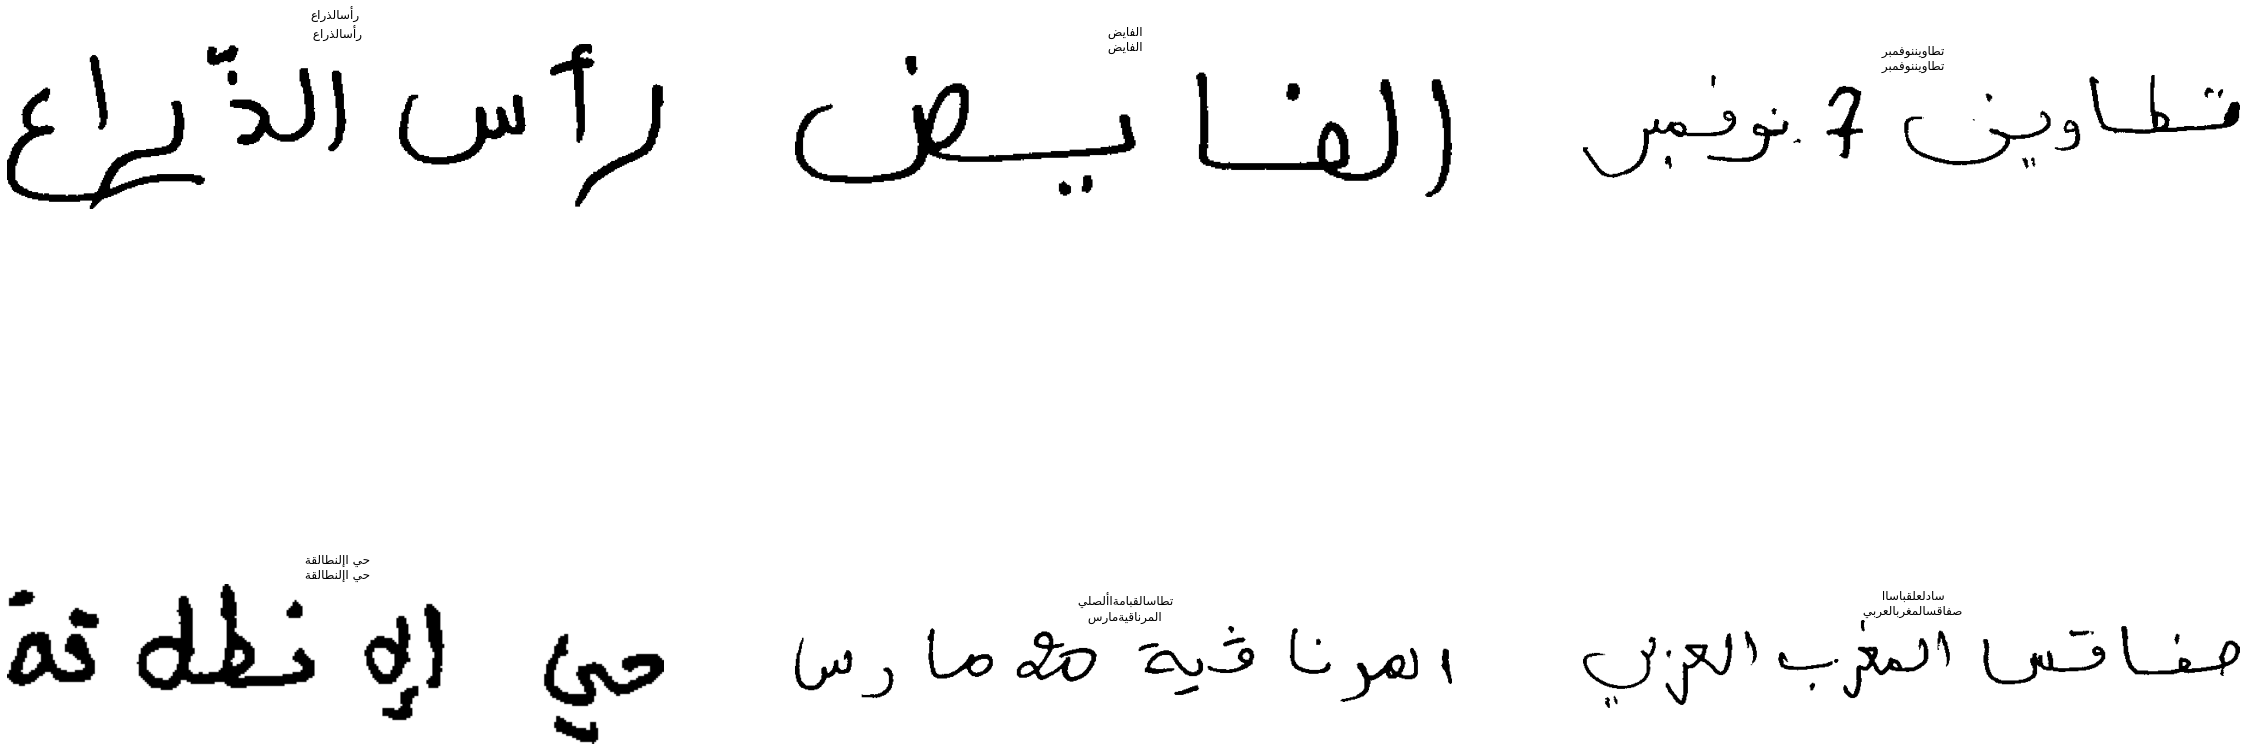

In [ ]:
# create figure
fig = plt.figure(figsize=(40, 28))
  
# setting values to rows and column variables
rows = 3
columns = 3
for i, img in enumerate(imgs):
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(img)
  plt.axis('off')
  predicted = get_display(arabic_reshaper.reshape(predicts[indexes[i]]))
  gted = get_display(arabic_reshaper.reshape(gts[indexes[i]]))
  plt.title(predicted + '\n' + gted)

# Live Testing

In [21]:
images_f = open('/content/drive/MyDrive/images.txt', 'r')
images = images_f.readlines()
images_f.close()

In [22]:
gts_f = open('/content/drive/MyDrive/predictions.txt', 'r')
gtss = gts_f.readlines()
gts_f.close()
gts = []
for gt in gtss:
  gts.append(gt.split(',')[-1].replace('\n', '').strip())


In [23]:
features = []
# load an image from file
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
for image in images:
  image = load_img(image.replace('\n', ''), target_size=(224, 224))
  image = img_to_array(image)
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)
  feature = model.predict(image)
  features.append(np.array(feature).T)
features = np.array(features)

553476096/553467096 [==============================] - 5s 0us/step


In [24]:
clf = pickle.load(open('/content/drive/MyDrive/model.sav', 'rb'))

In [25]:
predicts = []
key_list = list(chars.keys())
val_list = list(chars.values())
for image in features:
  img = image.reshape(image.shape[0], 1).T
  predicted_char = clf.predict(img)
  word = ''
  for char in predicted_char[0]:
    position = val_list.index(char)
    word = word + key_list[position]
  predicts.append(word)

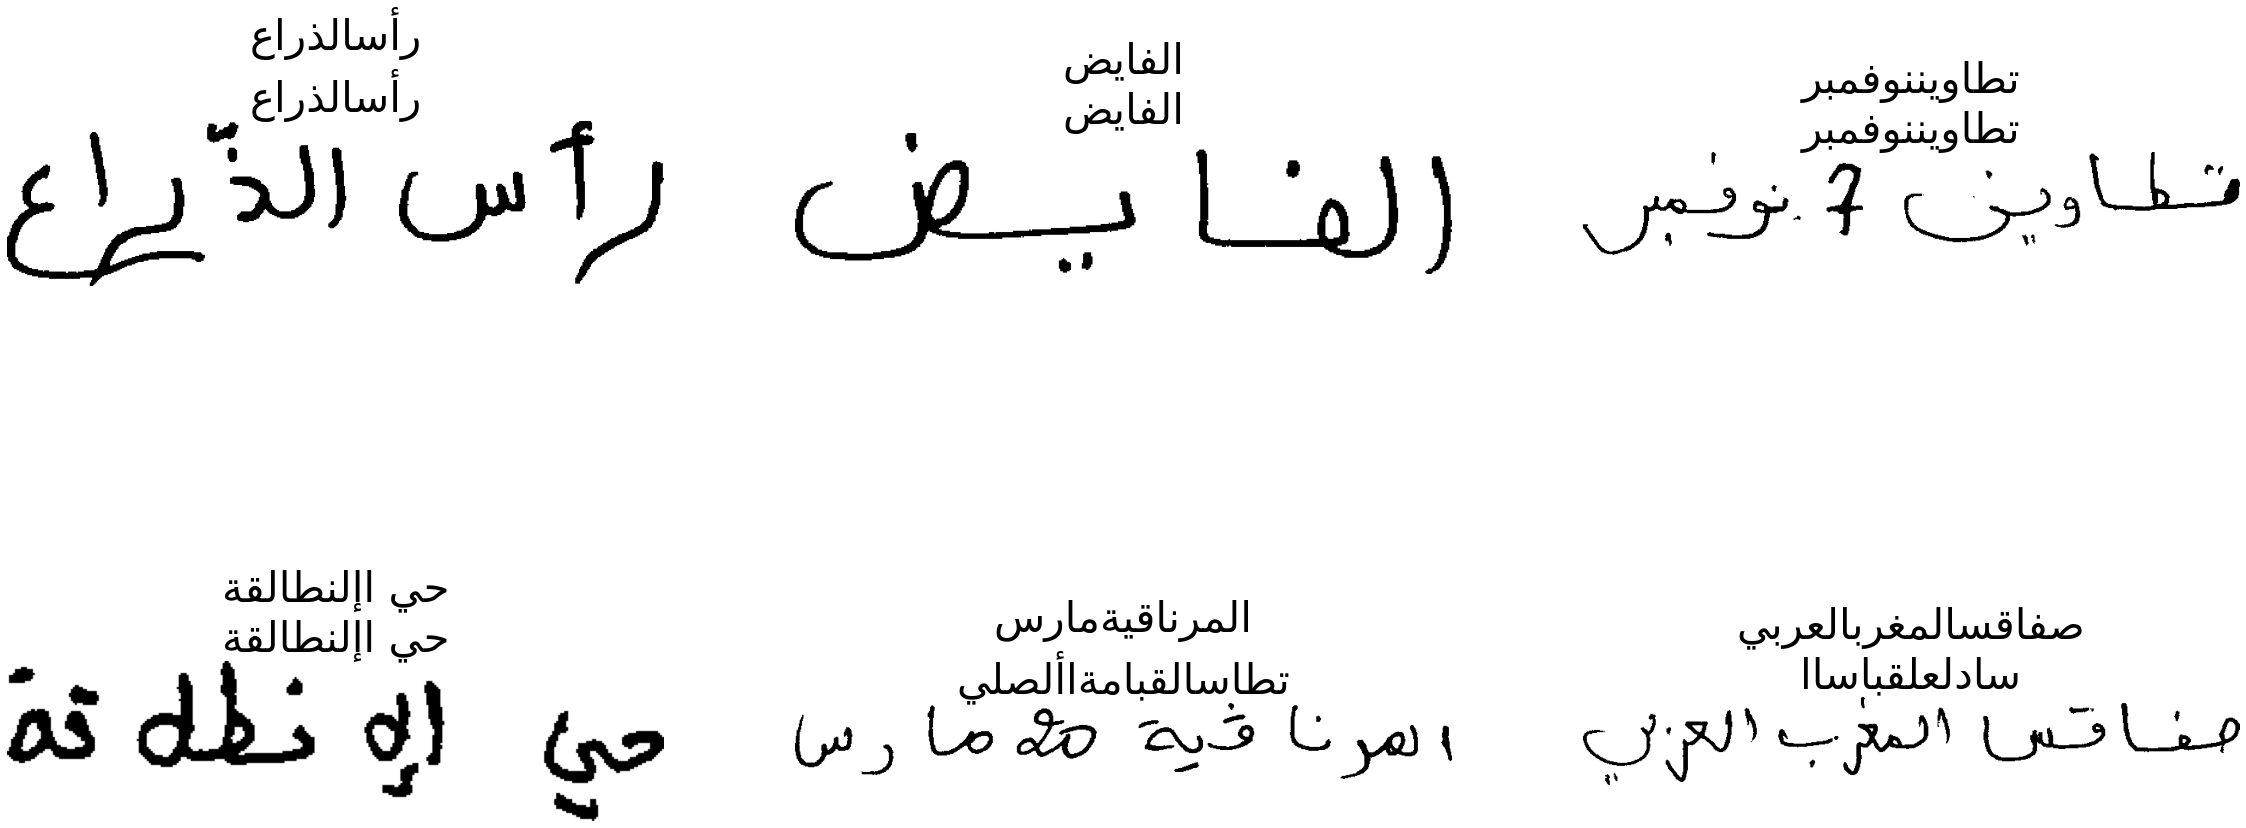

In [26]:
# create figure
fig = plt.figure(figsize=(40, 28))
  
# setting values to rows and column variables
rows = 3
columns = 3
for i, img in enumerate(images):
  img = cv2.imread(img.replace('\n', ''))
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(img)
  plt.axis('off')
  predicted = get_display(arabic_reshaper.reshape(predicts[i].strip()))
  gted = get_display(arabic_reshaper.reshape(gts[i]))
  plt.title(gted + '\n' + predicted, fontdict={'fontsize': 42})